
# **EDSA LANGUAGE HACKATHON**

The challenge is to build, train, test and deploy a model to take in text which is in any of South Africa's 11 official languages and identify which
language the text is in using any machine learning classification technique.


## Honour Code

I **MUHAMMAD**, **YAHYA**, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the EDSA honour code.

### Import all necessary libraries

In [51]:
# imports for data visualisation

import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
from textblob import TextBlob
from nltk.probability import FreqDist
#from wordcloud import WordCloud, ImageColorGenerator
import plotly.express as px
from sklearn.neighbors import KNeighborsClassifier
# imports for Natural Language  Processing
import pandas as pd
import numpy as np
import nltk
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize

# imports model prosessing
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from xgboost import XGBRFClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# imports Checking Acuracy
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
#from scikitplot.metrics import plot_roc, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import plot_roc_curve

# imports for other libraires
import pickle
import unicodedata
import warnings
warnings.filterwarnings("ignore")
#import en_core_web_sm
import spacy

### Load data and perform basic EDA

In [2]:
#TRAIN DATA

df_train = pd.read_csv('train_set.csv')
df_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


In [4]:
df_train.isnull().sum()

lang_id    0
text       0
dtype: int64

In [6]:
df_train.lang_id.value_counts()
len(df_train.lang_id.value_counts())

11

In [9]:
#create a dictionary of unique languages
lang_dict = dict(df_train.lang_id.value_counts())
lang_dict

{'xho': 3000,
 'eng': 3000,
 'nso': 3000,
 'ven': 3000,
 'tsn': 3000,
 'nbl': 3000,
 'zul': 3000,
 'ssw': 3000,
 'tso': 3000,
 'sot': 3000,
 'afr': 3000}

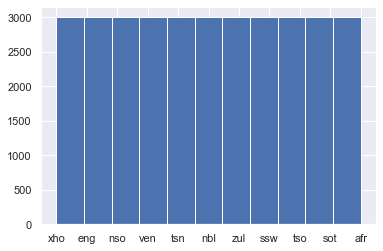

In [7]:
# visualize distribution of languages
df_train['lang_id'].hist(bins=11)
plt.show()

In [ ]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

In [11]:
lang_list = list(lang_dict.keys())
lang_list

['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso', 'sot', 'afr']

The resultiing coded list of the 11 unique languages is transcribed as:

['Tshi**ven**da',  'Xi**tso**nga',  '**Afr**ikaans', '**Eng**lish',  'Se**ts**wa**n**a',  'isi**Zul**u',  '**N**othern Se**so**tho',  'isi**Xho**sa',  '**N**de**b**e**l**e',  'si**Sw**ati',  'Se**sot**ho'].

In [30]:
#Random check for noise.
np.random.seed(50)
for text in range(10):
  num = np.random.randint(0, len(df_train))
  print('\n',df_train['text'][num])


 nakong ya gagwe mošomong o ile a hwetšwa molato mme a ahlolelwa kgolego ntle le tefišo goba ka kgopolo ya lekgotla la netefatšo ya boleng bja thuto le tlhahlo o palelwa ke go diragatša mešomo ya gagwe ka boikarabelo

 nokuba sele ulishishini elincinci kangakanani na kungumbono omhle ukuhlola iintshukumo zakho zonyaka kwicandelo loshishino okulo ze ujonge nokuba linempumelelo kangakanani na ishishini lakho unyaka nonyaka leliphi icebo elisebenzileyo nokuba kufuneka kutshintshe ntoni na

 tshenzhemo kha ḽifhasi ḽoṱhe yo sumbedza uri u valiwa ha zwikolo na zwiimiswa zwa pfunzo ya nṱha mavhengele a u rengisa na fhethu ha mushumo a zwo ngo thusa kha u imisa u phaḓalala ha vhulwadze vhudzuloni hazwo zwo ita uri hu vhe na u thithisea zwihulwane kha zwa matshilisano

 amathuba empangelo alinganayo - amathuba alinganayo nokuphathwa ngendlela eyamkelekileyo kwiindawo zentsebenzo ukuhleleleka kwangaphambili kuyasonjululwa ze ukungalingani kona kususwe ukuze kuphele nya

 provinces have budgeted

#### Observations on Train Data
* Train data looks relatively clean as there are no missing values except for punctuation noise from hyphenated words.
* No language had significantly few entries compared to another as the data visualization implies.
* The train data suggests that `Tshivenda` is most spoken and `Sesotho` is least, which is contrary to recent research by [Mary Alexander](https://southafrica-info.com/arts-culture/11-languages-south-africa/), stating that `IsiZulu` is most and `isiNdebele` is least spoken.
* I conclude here that `Tshivenda` and `Sesotho` are just the most recorded and least recorded respectively.

In [17]:
#TEST DATA

df_test = pd.read_csv('test_set.csv')
df_test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5682 entries, 0 to 5681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   5682 non-null   int64 
 1   text    5682 non-null   object
dtypes: int64(1), object(1)
memory usage: 88.9+ KB


In [22]:
df_test.isnull().sum()

index    0
text     0
dtype: int64

In [33]:
#Random check for noise.
np.random.seed(50)
for text in range(10):
  num = np.random.randint(0, len(df_test))
  print('\n',df_test['text'][num])


 <fn>GOV-ZA.106340En.2012-02-10.en.txt</fn>

 Na ke hakae moo o neng o lokela ho lekola dibenefiti tsa sekimi sa hao sa bongaka ka potlako Re a tseba hore hangata hona ho potlakile mme re ile ra sebedisa dikelello tsa rona ho fumana tharollo?

 E Ngizikhethele lokho engikukhethile futhi ngizanelisile ngesimo senzuzo ngaphansi kwalokhu engikukhethile.

 Ukubeletha ngokuhlinzwa Okuphuthumayo kwenziwa uma izinkinga zenzeka ngesikhathi sokubeletha. Ngesinye isikhathi, isidingo sokubeletha ngokuhlinzwa asicaci kuze kuqalwe ukubelethisa kanti abanye omama abahlose ukube-letha ngendlela ejwayelekile, kungadingeka ukuthi babelethe ngokuhlinzwa.

 Khutlotharo e e fa thoko ga seikokotlelo e ntsho.

 Ekotoerisme is natuur-gebaseerde toerisme wat ekologies volhoubaar is.

 Iskimu sokucandwa kwemida luxwebhu lomthetho elimisela amalungelo nezinyanzeliso ezingophuhliso somhlaba, kwaye sisetyenziswa kunye neminye imithetho enjengemithetho engokusingqongileyo, ukuze kulawulwe ukusetyenziswa nokuphuhl

#### Observations on Test Data
* Test data not as clean as train data as there are more punctuations in its text.
* There is no language identifier column.
* There are two index columns.
* Test data is larger than train data.

#### Conclusions based on EDA
* We can proceed to preprocessing with the test and train datasets.
* Punctuations should be removed from both data sets and one of the index columns for the test data should be dropped.
* Classification model should be trained with all of the train data set.

### Preprocessing

In [39]:
#Remove punctuations

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in df_test.text:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

In [45]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [41]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

In [53]:
y_train = df_train.lang_id
y_test = df_test.index

In [54]:
x_train = df_train.text
x_test = df_test.text

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words='english', min_df= .01)
x_train = vect.fit_transform(df_train['text'])

In [62]:
names = ['Logistic Regression', 'Nearest Neighbors',
         'Linear SVM', 'RBF SVM',
         'Decision Tree', 'Random Forest',  'AdaBoost']

In [57]:
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier()
]

In [58]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(x_train, y_train)

    print ('... predicting')
    y_pred = clf.predict(x_train)
    y_pred_test = clf.predict(x_test)

    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred)
    recall    = metrics.recall_score(y_train, y_pred)

    f1        = metrics.f1_score(y_train, y_pred)
    f1_test   = metrics.f1_score(y_test, y_pred_test)

    # Save the results to dictionaries
    models[name] = clf
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)

    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])


results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

print ('... All done!')

Fitting Logistic Regression model...
... predicting


ValueError: could not convert string to float: 'Mmasepala, fa maemo a a kgethegileng a letlelela kgato eo.'

In [59]:
results.sort_values('F1 Train', ascending=False)

AttributeError: 'list' object has no attribute 'sort_values'